# This notebook will plot the distribution of V1 cell responses to natural images. The data is 2P calcium responses in the mouse brain, from the Allen Brain Observatory. 

In [1]:
#load data (V1, natural image responses) for a sample mouse
import os
import platform
import pandas as pd
import numpy as np
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info




#sets the drive path of hard-disk containing observatory data, based on current OS
if platform.system()=='Windows':
    drive_path = 'g:/'
else:
    drive_path = '/Volumes/Brain2016/'
    

manifest_path = os.path.join(drive_path, 'BrainObservatory/manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)

cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
print(cre_lines)


all cre lines:

[u'Cux2-CreERT2', u'Emx1-IRES-Cre', u'Nr5a1-Cre', u'Rbp4-Cre', u'Rbp4-Cre_KL100', u'Rorb-IRES2-Cre', u'Scnn1a-Tg3-Cre']


In [2]:
# find all experiment containers that are from V1 and have natural gratings, and choose 1
rbp4_ecs = boc.get_experiment_containers(targeted_structures=['VISpm'],cre_lines=['Rbp4-Cre'])

container_id = rbp4_ecs[0]['id']
print len(rbp4_ecs)

exp = boc.get_ophys_experiments(experiment_container_ids=[container_id], 
                                stimuli=[stim_info.NATURAL_SCENES])[0]


print('Experiment container info:')
print exp



4
Experiment container info:
{'session_type': u'three_session_B', 'age_days': 80.0, 'imaging_depth': 375, 'experiment_container_id': 511511015, 'targeted_structure': u'VISpm', 'cre_line': u'Rbp4-Cre', 'id': 510706209}


In [3]:
# get the dff traces, and the stimulus, and pull out the raw dff traces in case we need these later
data_set = boc.get_ophys_experiment_data(exp['id'])
specimens=data_set.get_cell_specimen_ids()
timestamps, traces = data_set.get_dff_traces()


# stimulus info
# there are 118 (0-117) natural images. images were luminance matched, contrast-normalized, and resized.
# each image was presented for 250 ms, with no inter-image gray period
# each image was presented 50 times, in random order
# there was a blank sweep roughly once every 100 images. this is coded as a -1
# these 118*50=5900+59 images were split across three sessions

# pull out the stim info
stim_table = data_set.get_stimulus_table('natural_scenes') #table with image index and start and end times of each trial
num_trials = np.shape(stim_table)[0]
image_id = stim_table.frame; # this is the index of the image
num_images = 119;

# to acces the response during a particular trial, you would call
cell_loc=0
trial_loc=0
sample_trace = traces[cell_loc,stim_table.start[trial_loc]-28:stim_table.end[trial_loc]+28] # the added second before and
                                                                        # after the stimulus are to match
                                                                        # the allenSDK's definition of sweep response

    
mean_responses=[]
for i in range(num_trials):
    mean_responses.append(np.mean(traces[:,stim_table.start[i]-28:stim_table.end[i]+28],axis=1))


mean_responses = np.squeeze(np.array(mean_responses))


In [ ]:
# the mean trial responses are already pre-calculated in allenSDK, so we'll just use those instead of using the code above
# to extract single traces and calculating a trial average. But remember that the traces extracted from the NWB (as above) will 
# have a global (experiment-wide) dff whereas the traces calculated from the SDK will have a local dff. See sweep-response-test
# notebook. This shouldn't  produce huge differences in the sparicity stats, so we'll just use the allenSDK values.


# For each trial, the ΔF/F for each cell was calculated using the mean fluorescence of the preceding 1 second as the baseline Fo.

# The mean response to each image presentation was defined as the mean change in dff during the 0.5 second period 
# following the start of the image presentation compared to the 1 second preceding the image presentation.

In [4]:
# load pre-calculated trials and trial statisics from the allenSDK module
from allensdk.brain_observatory.natural_scenes import NaturalScenes
# allensdk.brain_observatory.natural_scenes.NaturalScenes(data_set, **kwargs)[source]
ns = NaturalScenes(data_set)
print("done analyzing natural scenes")


done analyzing natural scenes


In [5]:
# to get the sweep response
trial_responses = ns.sweep_response
print 'trial_responses is a dataframe of size' +np.str(np.shape(trial_responses))

# to get the sweep response for a particular cell and trial
sample_response = trial_responses[str(cell_loc)].iloc[trial_loc] 
print ('sample response is a vector of size ' +np.str(np.shape(sample_response))+' as it includes 1 sec before/after stim')

# to get the mean trial response 
trial_means = ns.mean_sweep_response
print ('trial_means is a dataframe of size ' +np.str(np.shape(trial_means)))

# to get the mean sweep response for a particular cell and trial
sample_mean = trial_means[str(cell_loc)].iloc[trial_loc] 
print ('sample_mean is a vector of size ' +np.str(np.shape(sample_mean)))


# We can also get the mean triaal responses averaged over all 50 presentation of the same image using ns.responses
# The response property of the stimulus-specific analysis objects is 3-D array organized with the following dimensions:
# 0: num. number of natural scene frames (118+blank)
# 1: num. cells + 1 (running speed)
# 2: 0=response mean, 1=response standard error of the mean, 2=number of signficant trials

# to get mean trial response averaged over all 50 presentations of an image
mean_over_image = ns.response[:,cell_loc,0] #outputs a 119x1 vector of mean resonse over each image

print '\nyou can get the mean response averaged over all 50 repeats of an image using the ns.response module'

#The peak property of the analysis object is a Pandas DataFrame of computed response metrics.
# For natural scences this includes:

# or you can just print the values for a particular cell
specimen_id = specimens[0]
specimen_ids = data_set.get_cell_specimen_ids()
cell_loc = np.argwhere(specimen_ids==specimen_id)[0][0]


print '\nyou can also get additional parameters using the ns.peak module'
print ns.peak.loc[cell_loc].head()

# we weon't use these here. I'm just posting the code here for reference.

trial_responses is a dataframe of size(5950, 61)
sample response is a vector of size (63L,) as it includes 1 sec before/after stim
trial_means is a dataframe of size (5950, 61)
sample_mean is a vector of size ()

you can get the mean response averaged over all 50 repeats of an image using the ns.response module

you can also get additional parameters using the ns.peak module
scene_ns                            86
response_reliability_ns             32
peak_dff_ns                   8.576338
ptest_ns                   0.005398507
p_run_ns                    0.01036388
Name: 0, dtype: object


kurtosis of distribution of responses, averaged over all unique images is 4.47680655421
kurtosis of distribution of responses to all images is 108.152472129
(119L,)


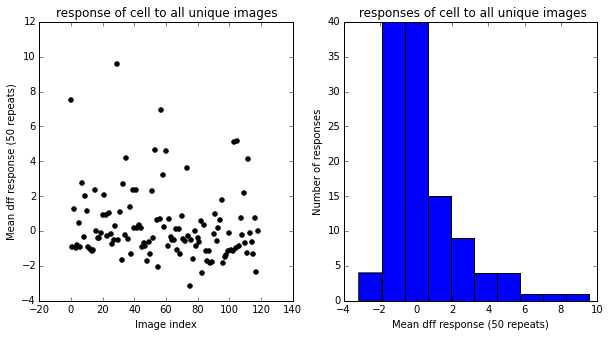

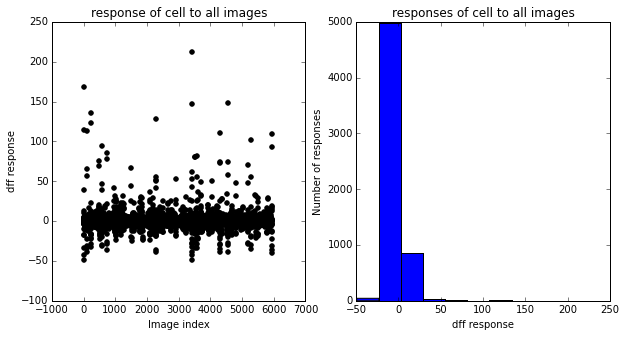

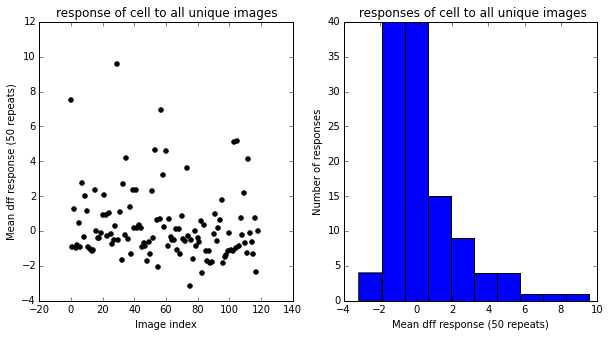

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

cell_loc=1

######################### plot the mean response of one cell to all unique images (mean over 50 repeats of each image)
mean_cell = np.squeeze(ns.response[:,cell_loc,0])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()

axs[0].scatter(np.arange(0,119,1), mean_cell, color='k')
axs[0].set_xlabel('Image index')
axs[0].set_ylabel('Mean dff response (50 repeats)')
axs[0].set_title('response of cell to all unique images')

axs[1].hist(mean_cell)
axs[1].set_ylabel('Number of responses')
axs[1].set_xlabel('Mean dff response (50 repeats)')
axs[1].set_title(' responses of cell to all unique images')
plt.tick_params(axis='y', which='both', top='off')

#measure the kurtosis of the histogram
k1=stats.kurtosis(mean_cell, axis=0, fisher=True, bias=True)
print 'kurtosis of distribution of responses, averaged over all unique images is '+ np.str(k1)

####################### now plot the response of one cell to all images

mean_cell = trial_means[str(cell_loc)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()

axs[0].scatter(np.arange(0,num_trials,1), mean_cell, color='k')
axs[0].set_xlabel('Image index')
axs[0].set_ylabel('dff response')
axs[0].set_title('response of cell to all images')

axs[1].hist(mean_cell)
axs[1].set_ylabel('Number of responses')
axs[1].set_xlabel('dff response ')
axs[1].set_title('responses of cell to all images')
plt.tick_params(axis='y', which='both', top='off')

#measure the kurtosis of the histogram
k1=stats.kurtosis(mean_cell, axis=0, fisher=True, bias=True)
print 'kurtosis of distribution of responses to all images is '+ np.str(k1)

####################### now see if you can get back the top plot (mean over each image), from the trial responses

mean_over_image=[]
for i in range(num_images):
    temp_ind=np.flatnonzero(image_id==i-1)
    mean_over_image.append(np.mean(trial_means[str(cell_loc)].iloc[temp_ind]))

print np.shape(mean_over_image)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()

axs[0].scatter(np.arange(0,num_images,1), mean_over_image, color='k')
axs[0].set_xlabel('Image index')
axs[0].set_ylabel('Mean dff response (50 repeats)')
axs[0].set_title('response of cell to all unique images')


axs[1].hist(mean_over_image)
axs[1].set_ylabel('Number of responses')
axs[1].set_xlabel('Mean dff response (50 repeats)')
axs[1].set_title(' responses of cell to all unique images')
plt.tick_params(axis='y', which='both', top='off')


# Now define the sparsity of each cell's respones using two metrics:
# 1) kurtosis of distribution of average response over 50 repeats
# 2) fraction of images that produce a significant resonse (based on z-scored resonse valuse)